# Analysis

## Utilities functions

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def convertJSONToPandas(path):
    if path.exists():
        with path.open("r") as f:
            results = json.load(f)
        rows = []
        for eps, models in results.items():
            for model, metrics in models.items():
                rows.append({
                    "epsilon": eps,
                    "model": model,
                    **metrics
	            })
        return pd.DataFrame(rows)
    return None

In [3]:
path = Path("./results_checkpoint.json")
df = convertJSONToPandas(path)

## Plots

### 1. Robust Accuracy vs. Epsilon (ε)

In [21]:
def plot_RobustAccVsEpsilon(df):
    plt.figure(figsize=(7.5, 4.5))

    for model_name, model_results in df.groupby("model"):
        plt.plot(model_results["epsilon"], model_results["robust_acc"], marker="o", linewidth=2, label=model_name)

    plt.xlabel("Epsilon (ε)")
    plt.ylabel("Robust Accuracy")
    plt.title("Robust accuracy vs. Epsilon (ε)")
    plt.ylim(0.0, 1.0)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8)
    plt.show()

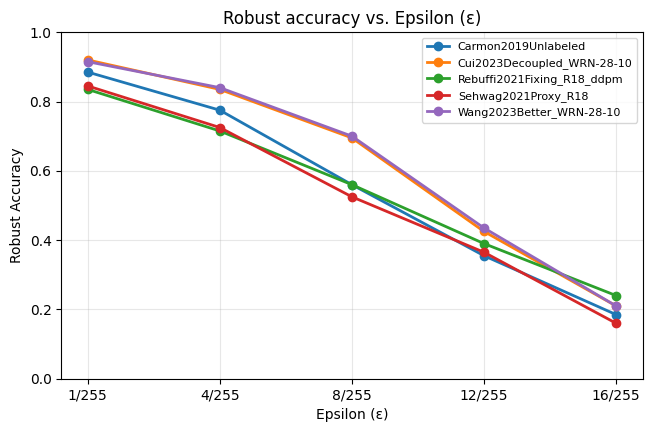

In [22]:
plot_RobustAccVsEpsilon(df)

### 2. Clean-Robust Accuracy drop

In [23]:
def plot_CleanRobustAccuracyDrop(df):
    plt.figure(figsize=(7.5, 4.5))

    for model_name, model_results in df.groupby("model"):
        drop = model_results["clean_acc"] - model_results["robust_acc"]
        plt.plot(model_results["epsilon"], drop, marker="o", linewidth=2, label=model_name)

    plt.xlabel("Epsilon (ε)")
    plt.ylabel("Clean−Robust Accuracy")
    plt.title("Clean-Robust Accuracy drop")
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8)
    plt.show()

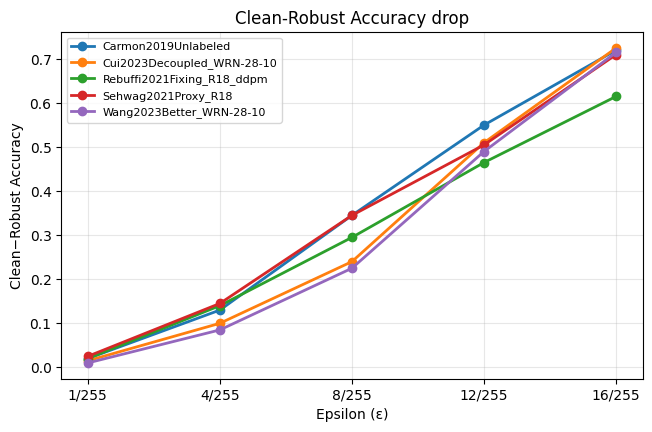

In [24]:
plot_CleanRobustAccuracyDrop(df)

In [35]:
def plot_CleanAccuracyDropHistogram(df):
    """Plot a grouped bar chart showing accuracy drops for each model across epsilons."""
    
    def eps_to_float(eps_str):
        num, denom = eps_str.split("/")
        return int(num) / int(denom)
    
    epsilons = sorted(df["epsilon"].unique().tolist(), key=eps_to_float)
    models = df["model"].unique().tolist()

    x = np.arange(len(epsilons))
    width = 0.8 / len(models)

    plt.figure(figsize=(7.5, 4.5))
    
    for i, model in enumerate(models):
        model_df = df[df["model"] == model]
        clean_acc = model_df["clean_acc"].iloc[0]
        drops = [
            clean_acc - model_df[model_df["epsilon"] == eps]["robust_acc"].iloc[0]
            for eps in epsilons
        ]
        plt.bar(x + i * width, drops, width=width, label=model)

    plt.xticks(x + width * (len(models) - 1) / 2, epsilons)
    plt.xlabel("Epsilon (ε)")
    plt.ylabel("Accuracy drop (clean − robust)")
    plt.title("Clean-Robust Accuracy drop")
    plt.legend(fontsize=8)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

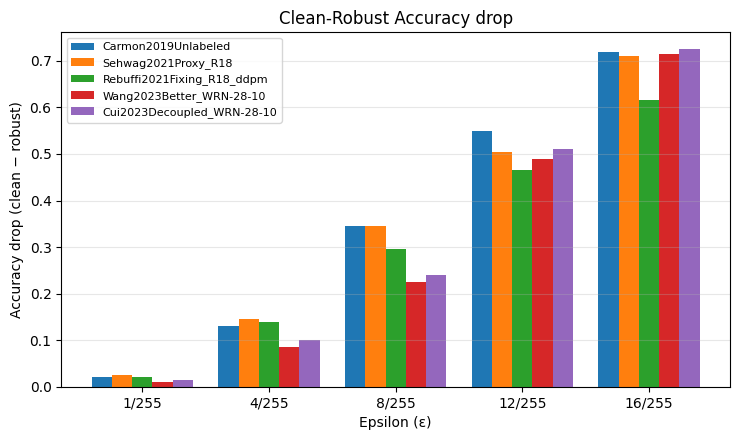

In [36]:
plot_CleanAccuracyDropHistogram(df)

### 3. Ranking across Epsilons (ε)

In [4]:
def plot_RankingAcrossEpsilons(df):
    plt.figure(figsize=(7.5, 4.5))
    
    # Load clean ranking data (epsilon = 0)
    clean_ranking_path = Path("./clean_ranking.json")
    clean_ranks = {}
    if clean_ranking_path.exists():
        with clean_ranking_path.open("r") as f:
            clean_data = json.load(f)
        # Extract ranks from the clean ranking data
        for eps_key, models in clean_data.items():
            for model, metrics in models.items():
                clean_ranks[model] = metrics["rank"]

    for model_name, model_results in df.groupby("model"):
        epsilons = ["0"] + model_results["epsilon"].tolist()
        ranks = []
        
        # Add clean rank (epsilon = 0) if available
        if model_name in clean_ranks:
            ranks.append(clean_ranks[model_name])
        else:
            ranks.append(np.nan)
        
        ranks.extend(model_results["rank"].tolist())
        
        plt.plot(epsilons, ranks, marker="o", linewidth=2, label=model_name)

    plt.xlabel("Epsilon (ε)")
    plt.ylabel("Ranking")
    plt.title("Ranking across Epsilons (ε)")
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

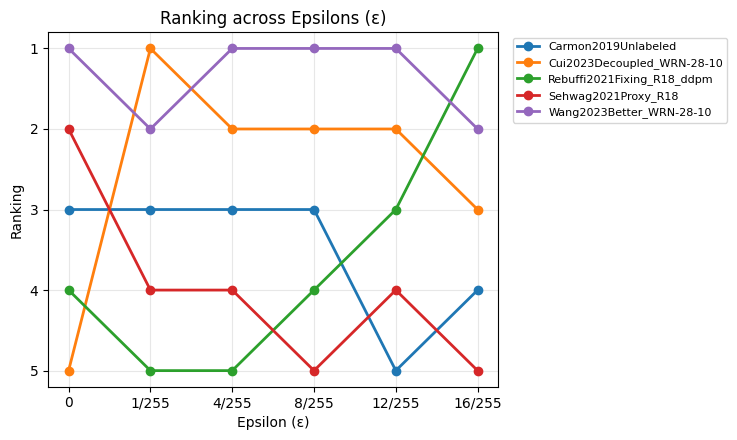

In [5]:
plot_RankingAcrossEpsilons(df)

### 4. Rank stability

In [48]:
def plot_RankStability(df):
    rows = []
    for model, g in df.groupby("model"):
        #g = g.sort_values("epsilon")
        ranks = g["rank"].values
        rows.append({
            "model": model,
            "rank_var": np.var(ranks),
            "max_jump": np.max(np.abs(np.diff(ranks))) if len(ranks) > 1 else 0
        })

    s = pd.DataFrame(rows).sort_values("rank_var", ascending=False)

    x = np.arange(len(s))
    w = 0.4

    plt.figure(figsize=(9, 4.5))
    plt.bar(x - w/2, s["rank_var"], width=w, label="Rank variance")
    plt.bar(x + w/2, s["max_jump"], width=w, label="Max adjacent rank jump")

    plt.xticks(x, s["model"], rotation=45, ha="right")
    plt.ylabel("Stability metric")
    plt.title("Ranking stability")
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.show()

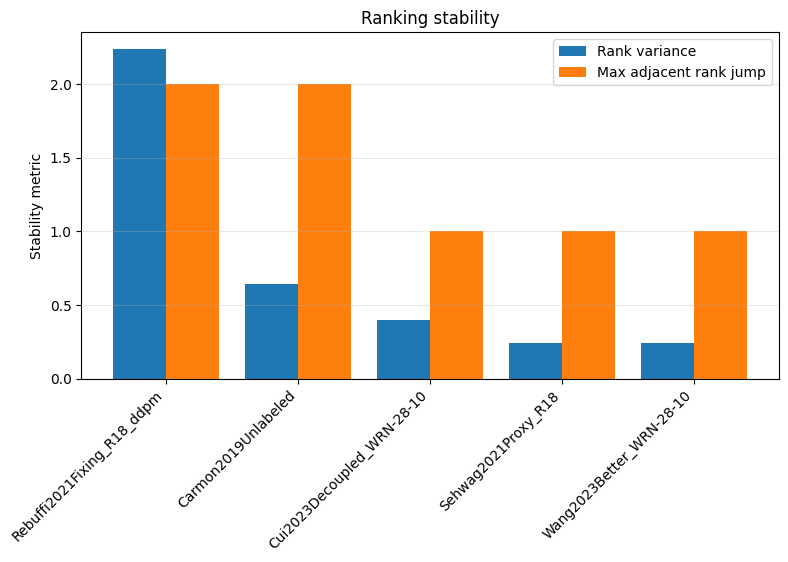

In [49]:
plot_RankStability(df)

## Tables

### 1. Robust Accuracy table

In [53]:
def showRobustAccTable(df):
    """Display a table with models as rows and epsilons as columns, showing robust accuracy and accuracy drop."""
    # Sort columns by epsilon value (numerically)
    def eps_to_float(eps_str):
        num, denom = eps_str.split("/")
        return int(num) / int(denom)

    # Create pivot table for robust accuracy
    robust_table = df.pivot_table(
        index="model",
        columns="epsilon",
        values="robust_acc",
        aggfunc="first"
    )
    robust_table = robust_table[sorted(robust_table.columns, key=eps_to_float)]

    # Create pivot table for clean accuracy
    clean_table = df.pivot_table(
        index="model",
        columns="epsilon",
        values="clean_acc",
        aggfunc="first"
    )
    clean_table = clean_table[sorted(clean_table.columns, key=eps_to_float)]

    # Calculate accuracy drop
    drop_table = clean_table - robust_table

    # Format: show robust_acc with drop in parentheses
    def format_with_drop(robust, drop):
        return f"{robust:.2%} (↓{drop:.2%})"

    table_formatted = robust_table.copy()
    for col in robust_table.columns:
        table_formatted[col] = [
            format_with_drop(robust_table.loc[idx, col], drop_table.loc[idx, col])
            for idx in robust_table.index
        ]

    return table_formatted

In [54]:
showRobustAccTable(df)

epsilon,1/255,4/255,8/255,12/255,16/255
model,,,,,
Carmon2019Unlabeled,88.50% (↓2.00%),77.50% (↓13.00%),56.00% (↓34.50%),35.50% (↓55.00%),18.50% (↓72.00%)
Cui2023Decoupled_WRN-28-10,92.00% (↓1.50%),83.50% (↓10.00%),69.50% (↓24.00%),42.50% (↓51.00%),21.00% (↓72.50%)
Rebuffi2021Fixing_R18_ddpm,83.50% (↓2.00%),71.50% (↓14.00%),56.00% (↓29.50%),39.00% (↓46.50%),24.00% (↓61.50%)
Sehwag2021Proxy_R18,84.50% (↓2.50%),72.50% (↓14.50%),52.50% (↓34.50%),36.50% (↓50.50%),16.00% (↓71.00%)
Wang2023Better_WRN-28-10,91.50% (↓1.00%),84.00% (↓8.50%),70.00% (↓22.50%),43.50% (↓49.00%),21.00% (↓71.50%)


### 2. Rank table

In [55]:
def showRankTable(df):
    """Display a table with models as rows and epsilons as columns, showing rank."""
    # Sort columns by epsilon value (numerically)
    def eps_to_float(eps_str):
        num, denom = eps_str.split("/")
        return int(num) / int(denom)

    # Create pivot table for rank
    rank_table = df.pivot_table(
        index="model",
        columns="epsilon",
        values="rank",
        aggfunc="first"
    )
    rank_table = rank_table[sorted(rank_table.columns, key=eps_to_float)]

    # Convert to int for cleaner display
    rank_table = rank_table.astype(int)

    return rank_table

In [56]:
showRankTable(df)

epsilon,1/255,4/255,8/255,12/255,16/255
model,,,,,
Carmon2019Unlabeled,3,3,3,5,4
Cui2023Decoupled_WRN-28-10,1,2,2,2,3
Rebuffi2021Fixing_R18_ddpm,5,5,4,3,1
Sehwag2021Proxy_R18,4,4,5,4,5
Wang2023Better_WRN-28-10,2,1,1,1,2
